In [1]:
import torch
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/filtered_data.csv')

In [3]:
df.shape

(31796, 4)

In [4]:
df['Protein ID'].nunique()

31796

In [5]:
any(df['Protein ID'].duplicated())  # no duplicates

False

#### Get clusters within whole dataset

In [14]:
!cd-hit -i ../data/seq.fasta -o ../data/ex_out -c 0.7 -n 4 -d 0 -T 0

Program: CD-HIT, V4.8.1 (+OpenMP), Apr 07 2021, 10:57:21
Command: cd-hit -i ../data/seq.fasta -o ../data/ex_out -c 0.7
         -n 4 -d 0 -T 0

Started: Sat Jul  1 12:54:28 2023
                            Output                              
----------------------------------------------------------------
total number of CPUs in the system is 12
Actual number of CPUs to be used: 12

Your word length is 4, using 5 may be faster!
total seq: 31796
longest and shortest : 1019 and 31
Total letters: 13047016
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 17M
Buffer          : 12 X 11M = 133M
Table           : 2 X 3M = 7M
Miscellaneous   : 0M
Total           : 157M

Table limit with the given memory limit:
Max number of representatives: 1075681
Max number of word counting entries: 80275423

# comparing sequences from          0  to       2271
..---------- new table with     1696 representatives
# comparing sequences from       2271  to       4379
-----

----------    297 remaining sequences to the next cycle
---------- new table with      203 representatives
# comparing sequences from      24372  to      24902
----------    273 remaining sequences to the next cycle
---------- new table with      201 representatives
# comparing sequences from      24629  to      25140
----------    313 remaining sequences to the next cycle
---------- new table with      148 representatives
# comparing sequences from      24827  to      25324
----------    289 remaining sequences to the next cycle
---------- new table with      159 representatives
# comparing sequences from      25035  to      25517
----------    273 remaining sequences to the next cycle
---------- new table with      157 representatives
# comparing sequences from      25244  to      25712
----------    243 remaining sequences to the next cycle
---------- new table with      148 representatives
# comparing sequences from      25469  to      25920
----------    245 remaining sequences to

#### Parse clusters

In [1]:
with open('../data/ex_out.clstr', 'r') as fi:
    data = fi.read()

In [2]:
clst = data.split('>Cluster')[1:]

In [3]:
len(clst)

23248

In [6]:
pat = re.compile(r'>.*?\s')

In [9]:
#clusters = dict.fromkeys(range(len(clst)))

In [10]:
def remove_(string):
    string = string.replace('...', '')
    string = string.replace('>', '')
    return string.strip()

In [11]:
clusters = {}
for i in range(len(clst)):
    hits = [remove_(item) for item in pat.findall(clst[i])]
    for item in hits:
        clusters[item] = i
        
    
        
    
    

In [20]:
def add_clst(x):
    return clusters[x]
        

In [21]:
df['clst'] = df['Protein ID'].apply(lambda x: add_clst(x))

In [22]:
df.head()

,Protein ID,simple_fasta,Species,Tm,clst
0,Q9M9P0_EXPA13,MQRFLLPLLFLALSPPAICHYSSSTSSPSSSSVSSDASEWRPARAT...,A.thaliana,40.301,16379
1,Q9LY74_VTE3,MASLMLNGAITFPKGLGSPGSNLHARSIPRPTLLSVTRTSTPRLSV...,A.thaliana,38.410,12962
2,O65784_CYP71B5,MSIFLCFLLLLPLSLIFLKKLLPSKGKLPPGPKGLPIIGNLHQFGR...,A.thaliana,36.698,6954
3,Q7XJ60_EB1A,MATNIGMMDSAYFVGRNEILTWINDRLHLNLSRVEEAASGAVQCQM...,A.thaliana,39.462,15960
4,Q8W4M5_PFP-BETA1,MAPALAVTRDLTAVGSPENAPAKGRASVYSEVQSSRINNTLPLPSV...,A.thaliana,41.074,5194


#### Number of unique clusters

In [23]:
df['clst'].nunique()

23248

#### Calculate the frequency of clusters by protein enrichment 

In [32]:
unique, counts = np.unique(df['clst'].values, return_counts=True)

In [33]:
sum(counts>1)

5617

In [34]:
sum(counts>2)

1516

In [35]:
sum(counts>3)

634

In [36]:
sum(counts>4)

287

In [37]:
sum(counts>5)

154

In [38]:
sum(counts>10)

19

In [39]:
sum(counts>30)

1

In [40]:
data = {'1': 5617, '2': 1516, '3': 634,
        '4': 287, '5': 154}

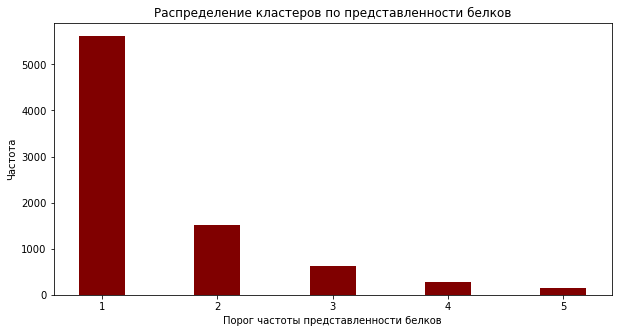

In [45]:
counts = list(data.keys())
freq = list(data.values())


fig = plt.figure(figsize=(10, 5))
plt.bar(counts, freq, color='maroon',
        width=0.4)
plt.xlabel('Порог частоты представленности белков')
plt.ylabel('Частота')
plt.title('Распределение кластеров по представленности белков')
plt.show()

#### Construct train and test data

In [59]:
embed_h1 = '../data/embeddings/embed_h1'
embed_h2 = '../data/embeddings/embed_h2'

#### Blind test from from Protstab2 paper

In [131]:
blind_test = pd.read_csv('../data/test_dataset.csv')

###### Make dataframe with proteins and embeddings

In [94]:
def make_embed_df(path):
    pattern = path+'/*.pt'
    files = glob.glob(pattern)
    embeddings, labels = [], []
    
    for item in files:
        entry = torch.load(item)
        labels.append(entry['label'])
        embeddings.append(entry['mean_representations'][33].numpy())
    df = pd.DataFrame(zip(labels, embeddings), columns=['Protein ID', 'repr'])
    return df
    
        
    

In [104]:
blind_test.head()

,Unnamed: 0,Protein ID,simple_fasta,Species,Tm
0,0,Q72HG4_TT_C1523,MREVEPLAERLRPRSLDEVLGQPHLTGPKGLLRRMLEAGRLSSMVL...,T.thermophilus,74.007
1,1,Q745T7_TT_P0220,MRLDPNHPRPTLQRPGWRSLEGHWDFALSEAEAPGGVRFDRKILVP...,T.thermophilus,77.065
2,2,Q72G97_recG,MTWEELEERLARGQDERTLFLPQDISPEDLARYAAGLANHKGGTLF...,T.thermophilus,72.153
3,3,Q745Z3_TT_P0162,MTKAKRTYEPWYWANAHTRLYMRRGYLLPGVSVEERVKEIAQRAEA...,T.thermophilus,73.594
4,4,Q72HN7_TT_C1449,MEALEEVLELLKLPHRGSATALEAEAFRRLAGFLEARGLKPSEIPF...,T.thermophilus,79.211


In [135]:
blind_test.shape

(3443, 5)

In [96]:
df_1 = make_embed_df(embed_h1)

In [97]:
df_2 = make_embed_df(embed_h2)

In [98]:
embed_df = pd.concat([df_1, df_2])

In [128]:
embed_df.head()

,Protein ID,repr
0,G3XAH6,"[0.01915554, -0.13713509, -0.009283804, 0.0860..."
1,F1R300_snrpa1,"[0.028856942, -0.06969996, 0.0069335345, 0.020..."
2,B2RU90_Prdm8,"[-0.04963684, -0.111743204, 0.010268072, 0.048..."
3,Q8BTW3_Exosc6,"[-0.078071445, 0.04592693, 0.066288136, -0.081..."
4,P37340_mdtK,"[-0.029140206, -0.059619486, -0.07758403, -0.0..."


In [110]:
embed_df = embed_df.drop_duplicates(subset=['Protein ID'], keep='first')

##### Merge embeddings with blind test data by Protein ID

In [132]:
blind_test = blind_test.merge(embed_df, on=['Protein ID'], how='inner')


In [133]:
blind_test = blind_test.iloc[:, 1:]

In [136]:
blind_test.shape

(3443, 5)

##### Merge embeddings with train data by Protein ID

In [117]:
train = df.merge(embed_df, on=['Protein ID'], how='inner')

In [120]:
train['group_Tm'] = train['Tm'].apply(lambda x: 0 if x <= 45 else 1 if x <= 75 else 2)

##### Delete test data from train 

In [127]:
train = train.loc[~train['Protein ID'].isin(blind_test['Protein ID'])]

In [89]:
train.to_csv('../data/train.csv', index=False)

In [62]:
blind_test.to_csv('../data/blind_test.csv', index=False)